# Looking for the smartest algorithm in the room

Machine Learning practice with the **Enron** Email Corpus and Financial Dataset.

---

Katie's enthusiasm is contractible, so I went ahead to learn a bit. Watching the documentary allowed me to learn quite some new things about that ugly side of the _American Dream_.

Here's to some more involvement through a different path.

## What is this about?
Using Machine Learning techniques, I will try to analyze the two combined datasets to try to predict who of the people that are part of the dataset might be persons of interest (poi).
I define a poi to be someone who might be worth further investigation, because he or she might be more closely involved in the Enron fraud case than other people who worked at the company at that time.

One feature that these predictions will be based on, is the label 'poi', that was manually assembled by Katie Malone from people proven to be involved in the fraud. (Source: http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm)
It therefore represents a key feature for the analysis.


In [354]:
#!/usr/bin/python

import sys
import pickle
import pprint
import numpy as np
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

%matplotlib inline
from matplotlib import pyplot as plt

In [355]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [356]:
# preparing a pandas DF for easier access
import pandas as pd

enron_df = pd.DataFrame(data_dict)
# better in the other format
enron_df = enron_df.transpose()

enron_df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


## Overview of the dataset

In [357]:
print "total number of data points:", len(enron_df)
print "of which {0} are POI and {1} are non-POI.".format(len(enron_df[enron_df.poi == 1]),
                                                         len(enron_df[enron_df.poi == 0]))

total number of data points: 146
of which 18 are POI and 128 are non-POI.


## Selecting Features
### Selection Mechanism
At first I wanted to know how often do I actually have data for the respective features, so I coded this up.
Initially I wanted to consider only features that are shared by at least 60% of the people in the dataset (where `feature != 'NaN'`). However, this did not include any data of the Email Corpus, so I reduced the treshold to 50%.

There are many features in the dataset that have a considerable amount of data points missing.

In [358]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

###
### 1 - SELECTING FEATURES
###

# a dict with the basic structure of the data, to keep count of occurences
count_dict = {'bonus': 0,
 'deferral_payments': 0,
 'deferred_income': 0,
 'director_fees': 0,
 'email_address': 0,
 'exercised_stock_options': 0,
 'expenses': 0,
 'from_messages': 0,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 0,
 'loan_advances': 0,
 'long_term_incentive': 0,
 'other': 0,
 'poi': 0,
 'restricted_stock': 0,
 'restricted_stock_deferred': 0,
 'salary': 0,
 'shared_receipt_with_poi': 0,
 'to_messages': 0,
 'total_payments': 0,
 'total_stock_value': 0}
# to see which features are present for many people, i count
for person, p_dict in data_dict.items():
	for key, value in p_dict.items():
		if value != "NaN":
			count_dict[key] += 1
# for better comparison i will use the percentage of total
amount_people = len(data_dict)
perc_dict = {}
for key, value in count_dict.items():
	perc_dict[key] = round((value * 100.0) / amount_people, 2)
#pprint.pprint(perc_dict)
# filtering for the more common features, with a treshhold of 50%
common_feature_list = []
for key, value in perc_dict.items():
	if value >= 50:
		common_feature_list.append(key)

# removing features I don't want to investigate (for justification
# see the ML_report_Enron file)
remove_list = ['to_messages', 'exercised_stock_options', 'email_address',
			'total_stock_value', 'expenses', 'from_messages', 'other', 'restricted_stock']
features_list = [feature for index, feature in enumerate(common_feature_list) if feature not in remove_list]
# ordering 'poi' to index = 0
features_list = features_list[4:] + features_list[:4]
print "number of features used: {0}\n".format(len(features_list))
pprint.pprint(features_list)

number of features used: 7

['poi',
 'shared_receipt_with_poi',
 'from_poi_to_this_person',
 'salary',
 'total_payments',
 'bonus',
 'from_this_person_to_poi']


Of the result:

```python
['salary', 'to_messages', 'total_payments', 'exercised_stock_options', 'bonus', 'email_address', 'total_stock_value', 'expenses', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'shared_receipt_with_poi', 'restricted_stock', 'from_poi_to_this_person']
```

I selected

```python
['poi', 'salary', 'bonus', 'total_payments', 'shared_receipt_with_poi', 'from_poi_to_this_person', 'from_this_person_to_poi' ]
```


#### out
`email_address` is a unique string for each person and therefore won't have any predictive power. `to_messages` and `from_messages` seems better encoded in `from_poi_to_this_person` and `from_this_person_to_poi`, considering that I will explore the data in correlation to pois (persons of interest).
I don't even know what `other` is, and neither am I familiar with `restricted_stock` and `exercised_stock_options`.
I can probably understand `total_stock_value` correctly, however I know that high-ranking pois were selling off their stocks of the company towards the end, and I just generally don't know enough about the stock market to handle these values well. I also am unsure about what `expenses` are logged in the so-named variable, so for this analysis I kept it aside.


#### in
What I therefore chose to further investigate and train my classifiers on, is `salary`, `bonus` and `total_payments`, for the more obvious financial-related features. I assume that pois might have a higher sum of money that they amassed (either through salaries, bonuses, or both), than non-pois working in the company. After all, the case is about people taking **money** that was not theirs to take, so the financial data should be able to show some trends there. 
Further I chose `from_poi_to_this_person` and `from_this_person_to_poi` from the email corpus data, to investigate a possible relationship indicated by pois sending an increased amount of emails between each other than towards non-pois.
And finally I also chose `shared_receipt_with_poi` from the financial dataset. This is another more exploratoy feature. I don't know exactly what it denotes, but it got me interested to look for trends here (and to properly understand what does this mean). I can imagine that pois were more likely to share receipts with other pois.

### Other Considerations
I decided not to employ a Decision Tree algorithm for selecting my features. My main reason for this was, that even though some now-discarded feature might do a good job in predicting pois, I found it dangerous to base this on features that have less than half of the data involved.
With 146 people, the dataset is anyways not very large, therefore I wanted to make sure to train and test my algorithms at least on a somewhat representable size.

## Outliers?
Checking whether all is sound in the data.

In [359]:
# reducing the dataframe for better overview
for c in enron_df.columns:
    if c not in features_list:
        enron_df.drop(c, axis=1, inplace=True)
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442
BADUM JAMES P,NaN,NaN,NaN,False,NaN,NaN,182466
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696


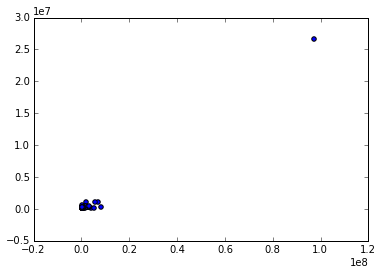

In [360]:
plt.scatter(enron_df['bonus'], enron_df['salary'])

Gotcha! Let's take a closer loook at this one all the way up there!

I had a little trouble here when trying to find the `max()` value of the columns. The code only returned me `NaN` as the max. After a while I figured that this is because the `'NaN'` values were actually **strings**, not `None` type. Here I figured this out and went ahead to transform them into actual `NaN`.

In [361]:
print enron_df['salary'][1]
print type(enron_df['salary'][1])

NaN
<type 'str'>


In [362]:
enron_df['salary'].isnull().head()

ALLEN PHILLIP K       False
BADUM JAMES P         False
BANNANTINE JAMES M    False
BAXTER JOHN C         False
BAY FRANKLIN R        False
Name: salary, dtype: bool

In [363]:
enron_df.replace(['NaN'], [None], inplace=True)
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442
BADUM JAMES P,NaN,NaN,NaN,False,NaN,NaN,182466
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696


In [364]:
enron_df['salary'].isnull().head()

ALLEN PHILLIP K       False
BADUM JAMES P          True
BANNANTINE JAMES M    False
BAXTER JOHN C         False
BAY FRANKLIN R        False
Name: salary, dtype: bool

In [365]:
print enron_df['salary'][1]
print type(enron_df['salary'][1])

nan
<type 'numpy.float64'>


Okay, with that out of the way, I can finally target my outlier.

In [366]:
outlier = enron_df['salary'].max()

In [367]:
print enron_df.loc[enron_df['salary'] == outlier]

          bonus  from_poi_to_this_person  from_this_person_to_poi    poi  \
TOTAL  97343619                      NaN                      NaN  False   

         salary  shared_receipt_with_poi  total_payments  
TOTAL  26704229                      NaN       309886585  


Yep. "Mr. Total" was **not** one of the main players in the fraud - this row can be safely removed.

In [368]:
enron_df = enron_df[enron_df.salary != outlier]
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442
BADUM JAMES P,NaN,NaN,NaN,False,NaN,NaN,182466
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696


In [369]:
print enron_df['salary'].max()

1111258.0


This looks more "reasonable". Let's give it up for the graphic.

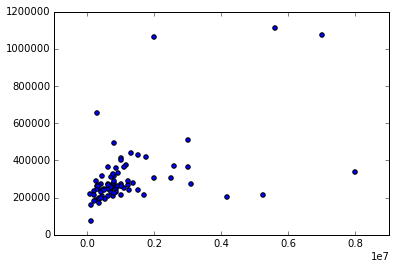

In [370]:
plt.scatter(enron_df['bonus'], enron_df['salary'])

Even though these remaining sums seem highly overpriced as well, these ones are most likely outliers of interest (oois). Some people got a lot of money.

In [371]:
# checking also the minimum
min_outlier = enron_df.salary.min()
print enron_df.loc[enron_df.salary == min_outlier]

                    bonus  from_poi_to_this_person  from_this_person_to_poi  \
BANNANTINE JAMES M    NaN                       39                        0   

                      poi  salary  shared_receipt_with_poi  total_payments  
BANNANTINE JAMES M  False     477                      465          916197  


Nothing wrong with this one, it seems.

Onto the other features.

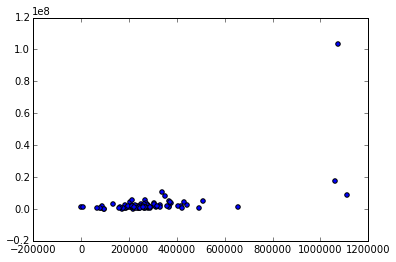

In [372]:
plt.scatter(enron_df.salary, enron_df.total_payments)

Another lone rider here, however he might be real...

In [373]:
outlier = enron_df.total_payments.max()
print enron_df.loc[enron_df.total_payments == outlier]

                 bonus  from_poi_to_this_person  from_this_person_to_poi  \
LAY KENNETH L  7000000                      123                       16   

                poi   salary  shared_receipt_with_poi  total_payments  
LAY KENNETH L  True  1072321                     2411       103559793  


Yep... That's one of our men...

In [374]:
# checking also the minimum
min_outlier = enron_df.total_payments.min()
print enron_df.loc[enron_df.total_payments == min_outlier]

                 bonus  from_poi_to_this_person  from_this_person_to_poi  \
MENDELSOHN JOHN    NaN                      NaN                      NaN   

                   poi  salary  shared_receipt_with_poi  total_payments  
MENDELSOHN JOHN  False     NaN                      NaN             148  


This person seems not very useful for doing any predictions, considering that he has only one value filled (`total payments`). Later I will check for and remove rows that have most of my chosen features missing.

Let's first take a look at the rest of the data.

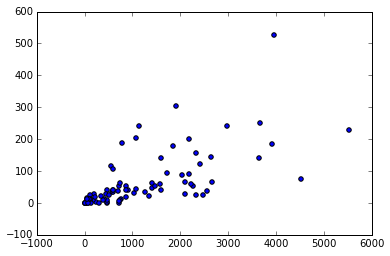

In [375]:
plt.scatter(enron_df.shared_receipt_with_poi, enron_df.from_poi_to_this_person)

In [376]:
def display_outlier(column_name):
    outlier = enron_df[column_name].max()
    print enron_df.loc[enron_df[column_name] == outlier]
    
display_outlier('shared_receipt_with_poi')

                    bonus  from_poi_to_this_person  from_this_person_to_poi  \
BELDEN TIMOTHY N  5249999                      228                      108   

                   poi  salary  shared_receipt_with_poi  total_payments  
BELDEN TIMOTHY N  True  213999                     5521         5501630  


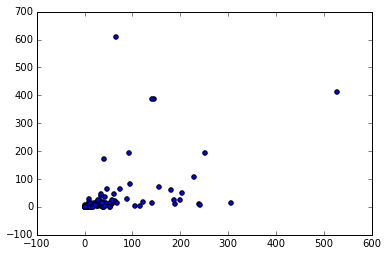

In [377]:
plt.scatter(enron_df.from_poi_to_this_person, enron_df.from_this_person_to_poi)

In [378]:
display_outlier('from_poi_to_this_person')
display_outlier('from_this_person_to_poi')

                   bonus  from_poi_to_this_person  from_this_person_to_poi  \
LAVORATO JOHN J  8000000                      528                      411   

                   poi  salary  shared_receipt_with_poi  total_payments  
LAVORATO JOHN J  False  339288                     3962        10425757  
                    bonus  from_poi_to_this_person  from_this_person_to_poi  \
DELAINEY DAVID W  3000000                       66                      609   

                   poi  salary  shared_receipt_with_poi  total_payments  
DELAINEY DAVID W  True  365163                     2097         4747979  


Yep, the rest is all to keep. Outlier detection terminated.

### Removing (near) empty rows
Because scarce data is probably not very useful for prediction, I will remove rows that have nearly all data missing of my chosen features.

Since the dataset is however rather small, I want to take a cautious approach and keep most rows, if possible. I will therefore remove only rows that have 2 or less features containing actual values. My choice for the threshold fell on 2, because **all** rows have an entry for `poi` (`True`/`False`). Therefore I am essentially only removing rows that have **no additional feature** containing a value.

This approach should prevent me from discarding too many of the anyway scarce rows, yet also get rid of entries that are more likely to distract than aid the prediction power of my algorithm-to-be.

In [379]:
print "number of rows before removing those with scarce feature data:", len(enron_df)
min_features_filled = 2
enron_df.dropna(axis='index', thresh=min_features_filled, inplace=True)
print "number of rows after removing those with scarce feature data:",  len(enron_df)

number of rows before removing those with scarce feature data: 145
number of rows after removing those with scarce feature data: 135


My approach removed another 10 rows from the dataset. This seems to be a reasonable amount and I can go forward to work with the cleaned-up dataset containing now 136 entries.

Further, `THE TRAVEL AGENCY IN THE PARK` that was a bogus firm that some of the people involved in the fraud were using for booking travel costs is obviously not a **person** in this fraud case. Therefore I will also remove it from the df. I've found out about this data point through inspecting the `enron61702insiderpay.pdf` file manually.

In [380]:
print enron_df.loc["THE TRAVEL AGENCY IN THE PARK"]

bonus                         NaN
from_poi_to_this_person       NaN
from_this_person_to_poi       NaN
poi                         False
salary                        NaN
shared_receipt_with_poi       NaN
total_payments             362096
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object


In [381]:
agency = "THE TRAVEL AGENCY IN THE PARK"
enron_df = enron_df.drop([agency])
len(enron_df)

134

In [382]:
#print enron_df.loc["THE TRAVEL AGENCY IN THE PARK"]

## A new feature

In [383]:
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442
BADUM JAMES P,NaN,NaN,NaN,False,NaN,NaN,182466
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696


In [384]:
def email_perc(row):
    one_way = row['from_this_person_to_poi']
    the_other = row['from_poi_to_this_person']
    
    ratio = 0
    if one_way != 0 and the_other != 0:
        ratio = float(one_way) / the_other
    return ratio

In [385]:
enron_df["sent_received_ratio"] = enron_df.apply(lambda row: email_perc(row), axis=1)
enron_df.head()

,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments,sent_received_ratio
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442,1.382979
BADUM JAMES P,NaN,NaN,NaN,False,NaN,NaN,182466,NaN
BANNANTINE JAMES M,NaN,39,0,False,477,465,916197,0.000000
BAXTER JOHN C,1200000,NaN,NaN,False,267102,NaN,5634343,NaN
BAY FRANKLIN R,400000,NaN,NaN,False,239671,NaN,827696,NaN


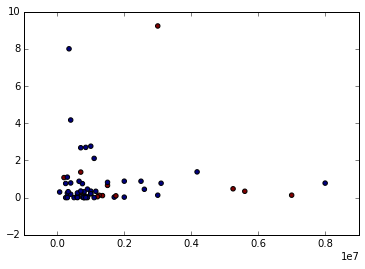

In [386]:
plt.scatter(enron_df.bonus, enron_df.sent_received_ratio, c=enron_df.poi)

## display_outlier('sent_received_ratio')

Seems I'll need a non-empty-value dataset for building my classifiers. `0` would work, however this would be false information because for the `NaN` values there is actually now record, and not a `0` record.

In [387]:
enron_no_na = enron_df.dropna()
print len(enron_no_na)
enron_no_na.head()

61


,bonus,from_poi_to_this_person,from_this_person_to_poi,poi,salary,shared_receipt_with_poi,total_payments,sent_received_ratio
ALLEN PHILLIP K,4175000,47,65,False,201955,1407,4484442,1.382979
BECK SALLY W,700000,144,386,False,231330,2639,969068,2.680556
BELDEN TIMOTHY N,5249999,228,108,True,213999,5521,5501630,0.473684
BERGSIEKER RICHARD P,250000,4,0,False,187922,233,618850,0.000000
BIBI PHILIPPE A,1000000,23,8,False,213625,1336,2047593,0.347826


In [388]:
enron_median = enron_df.fillna(enron_df.median().to_dict())
print len(enron_median)

134


In [389]:
# reformat the pandas df to a dict, for further processing with the lesson code
my_dataset = enron_df.to_dict(orient='index')
no_na_dataset = enron_no_na.to_dict(orient='index')
median_dataset = enron_median.to_dict(orient='index')

#print my_dataset['METTS MARK'], '\n'
#print no_na_dataset['METTS MARK'], '\n'
#print median_dataset['ALLEN PHILLIP K']

Here I'll be choosing the final features_list, that will exclude the two features `from_this_person_to_poi` and `from_poi_to_this_person`, and instead include the newly created ratio `sent_received_ratio`.

In [390]:
#features_list.remove('from_this_person_to_poi')
#features_list.remove('from_poi_to_this_person')
features_list.append('sent_received_ratio')

In [391]:
print features_list

['poi', 'shared_receipt_with_poi', 'from_poi_to_this_person', 'salary', 'total_payments', 'bonus', 'from_this_person_to_poi', 'sent_received_ratio']


In [392]:
### Extract features and labels from datasets for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# creating a dataset without NaN values (removing the rows that contain NaN)
no_na_data = featureFormat(no_na_dataset, features_list, sort_keys = True)
no_na_labels, no_na_features = targetFeatureSplit(no_na_data)

# creating a dataset with NaN replaced by the median
median_data = featureFormat(median_dataset, features_list, sort_keys = True)
median_labels, median_features = targetFeatureSplit(median_data)

## Classifiers

Splitting my data into test and training data. I'll be using 30% of the data for testing purposes.

Because there are a bunch of `NaN` values in the dataset, I tried to versions of analysis with my dataset:

1. removing the rows that contain `NaN` values
2. filling them with the **median**

I decided for the median over the mean, because **outliers** (in the form of at least the already identified pois) are present and important to the data and the prediction. When using the mean on the now-empty values, these outliers would severly alter the distribution. Therefore I chose the median, because it is resisting outlier-influence.

In [393]:
from sklearn.cross_validation import train_test_split

# features without filtering
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)
# features filtered, NaN values removed
no_na_features_train, no_na_features_test, no_na_labels_train, no_na_labels_test = train_test_split(no_na_features, no_na_labels, test_size=0.3, random_state=42)
# features filtered, NaN replaced with the median
median_features_train, median_features_test, median_labels_train, median_labels_test = train_test_split(median_features, median_labels, test_size=0.3, random_state=42)

# creating lists:
full_feat_list = [features_train, features_test, labels_train, labels_test]
no_na_list = [no_na_features_train, no_na_features_test, no_na_labels_train, no_na_labels_test]
median_list = [median_features_train, median_features_test, median_labels_train, median_labels_test]

In [403]:
def test_classifier(classifier_obj, data, scale=False):
    """Measures the time and accuracy of a given classifier.
    
    Takes as input a classifiert object (tuned or untuned)
    and a list containing the training and testing features and labels
    in this form:
    data = [features_train, features_test, labels_train, labels_test]
    Prints processing time and overall accuracy score.
    """
    from time import time
    from sklearn.metrics import accuracy_score
    from sklearn.preprocessing import MinMaxScaler
    
    # scaling the data when the type of algorithm demands this
    if scale == True:
        scaler = MinMaxScaler()
        features_train = scaler.fit_transform(data[0])
        features_test = scaler.transform(data[1])
    else:
        features_train = data[0]
        features_test = data[1]
    labels_train = data[2]
    labels_test = data[3]
    
    ### uncomment for information about time performance and accuracy ###
    ## taking the time the algorithm runs
    #t0 = time()
    classifier_obj.fit(features_train, labels_train)
    #print "training time:", round(time()-t0, 3), "s"
    
    ## taking time for prediction
    #t1 = time()
    pred = classifier_obj.predict(features_test)
    #print "predicting time:", round(time()-t1, 3), "s"
    
    #acc = accuracy_score(labels_test, pred)
    #print "accuracy:", acc
    
    print construct_CM(labels_test, pred)
    print calculate_f1(labels_test, pred)

In [404]:
def get_CM_nums(true_labels, predictions, CM_type):
    """Calculates the number of elements in the different cells of a confusion matrix.

    Takes as input the true labels and the predictions, both as lists.
    Further a specification of the metric wanted as an abbreviated string:
    'TP' for True Positives, 'FP' for False Positives
    'TN' for True Negatives, 'FN' for False Negatives
    Returns the amount of the specified metric.
    """
    import numpy as np
    
    if CM_type == "TP" or CM_type == "TN":
        if CM_type == "TP":
            CM_type = 1
        elif CM_type == "TN":
            CM_type = 0
        cpp = [1 for j in zip(true_labels, predictions) if j[0] == j[1] and j[1] == CM_type]
    elif CM_type == "FP" or CM_type == "FN":
        if CM_type == "FP":
            CM_type = 1
        elif CM_type == "FN":
            CM_type = 0
        cpp = [1 for j in zip(true_labels, predictions) if j[0] != j[1] and j[1] == CM_type]
    else:
        print "error, please enter TP, TN, FP, or FN."
    num_cpp = np.sum(cpp)
    return int(num_cpp)

def construct_CM(true_labels, predictions):
    """Wrapper function to calculate the confusion matrix and returns a formatted string.

    Takes as input the true labels and the predictions, both as lists.
    Calls get_CM_nums() with all possible inputs (TP, FP, TN, FN)
    Returns a formatted string representing the confusion martrix that is easy to read.
    """
    num_TP = get_CM_nums(true_labels, predictions, "TP")
    num_TN = get_CM_nums(true_labels, predictions, "TN")
    num_FP = get_CM_nums(true_labels, predictions, "FP")
    num_FN = get_CM_nums(true_labels, predictions, "FN")

    return """confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  {0}  |  {3}
class  | No  |  {2}  |  {1}""".format(num_TP, num_TN, num_FP, num_FN)

def calculate_f1(true_labels, predictions):
    """Calculates statistical metrics for the classifier's prediction.
    
    Takes as input the true labels and the predictions, both as lists.
    Returns a string containing the scores for precision recall and the f1-score.
    """
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1_score =  f1_score(true_labels, predictions)
    return """precision: {0}
recall:    {1}
f1_score:  {2}""".format(precision, recall, f1_score)

In [405]:
def test_a_lot(training_test_list):
    """Wrapper function that calculates performance results for different classifiers and prints the results.
    
    Takes as input a list of test and training data in the following form:
    'training_test_list = [features_train, features_test, labels_train, labels_test]'
    Calls the functions test_classifier() on Naive Bayes, SVM (with different settings),
    Decision Trees (with different settings), ans K-nearest neighbors (with different settings).
    Prints all results in formatted output.
    """
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier

    print "PERFORMANCE RESULTS OF DIFFERENT CLASSIFIERS"

    ### Naive Bayes
    print "\n\n\n### NAIVE BAYES ###"
    clf = GaussianNB()
    test_classifier(clf, training_test_list)


    ### Support Vector Machines
    print "\n\n\n### SUPPORT VECTOR MACHINES ###"
    # 'rbf' is the default kernel used
    print "# with 'rbf' kernel"
    clf = SVC()
    test_classifier(clf, training_test_list, scale=True)
    print '\n'

    # 'sigmoid'
    print "# with 'sigmoid' kernel"
    clf = SVC(kernel="sigmoid")
    test_classifier(clf, training_test_list, scale=True)


    ### Decision Trees
    print "\n\n\n### DECISION TREES ###"
    # 'max_features' default is None = n_features
    print "# using all features"
    clf = DecisionTreeClassifier()
    test_classifier(clf, training_test_list)
    print '\n'

    # 'sqrt'
    print "# using the square root of the features"
    clf = DecisionTreeClassifier(max_features="sqrt")
    test_classifier(clf, training_test_list)
    print '\n'

    # 'log2'
    print "# using the log2 of the features"
    clf = DecisionTreeClassifier(max_features="log2")
    test_classifier(clf, training_test_list)
    print '\n'
    
    # running the Decision Tree for all possible feature amounts
    for i in range(1,6):
        print "# using {0} feature(s)".format(i)
        clf = DecisionTreeClassifier(max_features=i)
        test_classifier(clf, training_test_list)
        print '\n'


    ### K-nearest Neighbours
    print "\n\n\n### K-NEAREST NEIGHBORS ###"
    # 'n_neighbors' default is 5
    print "# with k = 6 (all features)"
    neigh = KNeighborsClassifier(n_neighbors=6)
    test_classifier(neigh, training_test_list, scale=True)
    print '\n'
    
    # 'n_neighbors' default is 5
    print "# with k = 5"
    neigh = KNeighborsClassifier()
    test_classifier(neigh, training_test_list, scale=True)
    print '\n'

    # running kNN for some different amounts of neighbors
    for i in range(1,5):
        print "# with k =", i
        neigh = KNeighborsClassifier(n_neighbors=i)
        test_classifier(neigh, training_test_list, scale=True)
        print '\n'

In [407]:
test_a_lot(no_na_list)

PERFORMANCE RESULTS OF DIFFERENT CLASSIFIERS



### NAIVE BAYES ###
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  1  |  4
class  | No  |  3  |  11
precision: 0.25
recall:    0.2
f1_score:  0.222222222222



### SUPPORT VECTOR MACHINES ###
# with 'rbf' kernel
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  5
class  | No  |  0  |  14
precision: 0.0
recall:    0.0
f1_score:  0.0


# with 'sigmoid' kernel
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  5
class  | No  |  0  |  14
precision: 0.0
recall:    0.0
f1_score:  0.0



### DECISION TREES ###
# using all features
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  3  |  2
class  | No  |  5  |  9
precision: 0.375
recall:    0.6
f1_score:  0.461538461538


# using the square root of the fea

In [496]:
test_a_lot(median_list)

PERFORMANCE RESULTS OF DIFFERENT CLASSIFIERS



### NAIVE BAYES ###
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  3
class  | No  |  6  |  32
precision: 0.0
recall:    0.0
f1_score:  0.0



### SUPPORT VECTOR MACHINES ###
# with 'rbf' kernel
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  3
class  | No  |  0  |  38
precision: 0.0
recall:    0.0
f1_score:  0.0


# with 'sigmoid' kernel
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  3
class  | No  |  0  |  38
precision: 0.0
recall:    0.0
f1_score:  0.0



### DECISION TREES ###
# using all features
confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  0  |  3
class  | No  |  6  |  32
precision: 0.0
recall:    0.0
f1_score:  0.0


# using the square root of the features
confusion matrix: 

## Tuning
I've received the best F1-scores using **Decision Trees**, so this has become my Classifier of choice. In the following part I will try to figure out what set of features yields the best result.

In [409]:
print features_list

['poi', 'shared_receipt_with_poi', 'from_poi_to_this_person', 'salary', 'total_payments', 'bonus', 'from_this_person_to_poi', 'sent_received_ratio']


In [418]:
def test_feature_combinations(features_list):
    from feature_format import featureFormat, targetFeatureSplit
    from sklearn.cross_validation import train_test_split
    from sklearn.tree import DecisionTreeClassifier
    
    ### Extract features and labels from datasets for local testing
    no_na_data = featureFormat(no_na_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(no_na_data)
    
    # new features filtered, NaN values removed
    features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                labels,
                                                                                test_size=0.3,
                                                                                random_state=42)
    
    clf = DecisionTreeClassifier()
    
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    
    print construct_CM(labels_test, pred)
    print calculate_f1(labels_test, pred)

In [414]:
import math
print "possible combinations:", math.factorial(6)

possible combinations: 720


In [415]:
testlist = ["a","b","c","d"]

all_list = []
for c in testlist:
    a_list = []
    for cc in testlist:
        if c != cc:
            comb = c + cc
        else:
            comb = c
        a_list.append(comb)
    all_list.append(a_list)
    
print all_list

[['a', 'ab', 'ac', 'ad'], ['ba', 'b', 'bc', 'bd'], ['ca', 'cb', 'c', 'cd'], ['da', 'db', 'dc', 'd']]


In [419]:
features = ['poi',
            'shared_receipt_with_poi',
            'from_poi_to_this_person',
            'salary',
            'total_payments',
            'bonus',
            'from_this_person_to_poi',
            'sent_received_ratio']

test_feature_combinations(features)

confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  3  |  2
class  | No  |  5  |  9
precision: 0.375
recall:    0.6
f1_score:  0.461538461538


In [433]:
features = ['poi',
            'shared_receipt_with_poi',
            'salary',
            'total_payments',
            'bonus']

test_feature_combinations(features)

confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  2  |  3
class  | No  |  3  |  11
precision: 0.4
recall:    0.4
f1_score:  0.4


In [422]:
features = ['poi',
            'salary',
            'bonus']

test_feature_combinations(features)

confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  1  |  4
class  | No  |  8  |  6
precision: 0.111111111111
recall:    0.2
f1_score:  0.142857142857


In [426]:
features = ['poi',
            'from_poi_to_this_person',
            'from_this_person_to_poi',
            'sent_received_ratio']

test_feature_combinations(features)

confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  1  |  3
class  | No  |  0  |  14
precision: 1.0
recall:    0.25
f1_score:  0.4


In [436]:
features = ['poi',
            'total_payments']

test_feature_combinations(features)

confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  1  |  4
class  | No  |  3  |  11
precision: 0.25
recall:    0.2
f1_score:  0.222222222222


In [439]:
features = ['poi',
            'shared_receipt_with_poi']

test_feature_combinations(features)

confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  3  |  2
class  | No  |  3  |  11
precision: 0.5
recall:    0.6
f1_score:  0.545454545455


In [438]:
features = ['poi',
            'bonus']

test_feature_combinations(features)

confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  2  |  3
class  | No  |  2  |  12
precision: 0.5
recall:    0.4
f1_score:  0.444444444444


Okay, so this is a bit awkward. Let's do it more beter ; )

Here I will calculate the feature importance through using an overfit Decision Tree. I will then perform this calculation 10 times and select all features that show up in either of the iterations.
These will be the features I will use.

In [489]:
print features_list

def get_most_important_features():
    # creating the overfitted tree
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score

    no_na_data = featureFormat(no_na_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(no_na_data)
        
    # new features filtered, NaN values removed
    features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                                    labels,
                                                                                    test_size=0.3,
                                                                                    random_state=42)

    clf = DecisionTreeClassifier()
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    acc = accuracy_score(labels_test, pred)
    print "overfitted accuracy", acc

    # calculating feature importances
    feat_imp = clf.feature_importances_
    # print the most important (common) ones
    print feat_imp
    for index, feature in enumerate(feat_imp):
        if feature > 0.2:
            print "spot:", index, ":", features_list[index+1], " | value:", feature

['poi', 'shared_receipt_with_poi', 'from_poi_to_this_person', 'salary', 'total_payments', 'bonus', 'from_this_person_to_poi', 'sent_received_ratio']


In [494]:
for i in range(10):
    get_most_important_features()
    print "\n"

overfitted accuracy 0.631578947368
[ 0.26284585  0.          0.          0.34904226  0.18333333  0.09871795
  0.10606061]
spot: 0 : shared_receipt_with_poi  | value: 0.262845849802
spot: 3 : total_payments  | value: 0.349042262086


overfitted accuracy 0.684210526316
[ 0.25711662  0.          0.          0.26408199  0.38008344  0.09871795
  0.        ]
spot: 0 : shared_receipt_with_poi  | value: 0.257116620753
spot: 3 : total_payments  | value: 0.264081987402
spot: 4 : bonus  | value: 0.380083443127


overfitted accuracy 0.631578947368
[ 0.26284585  0.          0.          0.34904226  0.18333333  0.
  0.20477855]
spot: 0 : shared_receipt_with_poi  | value: 0.262845849802
spot: 3 : total_payments  | value: 0.349042262086
spot: 6 : sent_received_ratio  | value: 0.204778554779


overfitted accuracy 0.631578947368
[ 0.26284585  0.          0.          0.34904226  0.18333333  0.20477855
  0.        ]
spot: 0 : shared_receipt_with_poi  | value: 0.262845849802
spot: 3 : total_payments  | valu

In [488]:
features = ['poi',
            'shared_receipt_with_poi',
            'total_payments',
            'from_this_person_to_poi',
            'sent_received_ratio',
            'bonus']

test_feature_combinations(features)

confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  3  |  2
class  | No  |  4  |  10
precision: 0.428571428571
recall:    0.6
f1_score:  0.5


Which brings me a consistently rather high F1-score. Yay. : )

In [495]:
features = ['poi',
            'shared_receipt_with_poi',
            'total_payments',
            'from_this_person_to_poi',
            'sent_received_ratio',
            'bonus']


for i in range(10):
    test_feature_combinations(features)
    print "\n"

confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  2  |  3
class  | No  |  4  |  10
precision: 0.333333333333
recall:    0.4
f1_score:  0.363636363636


confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  3  |  2
class  | No  |  4  |  10
precision: 0.428571428571
recall:    0.6
f1_score:  0.5


confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  3  |  2
class  | No  |  4  |  10
precision: 0.428571428571
recall:    0.6
f1_score:  0.5


confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  3  |  2
class  | No  |  4  |  10
precision: 0.428571428571
recall:    0.6
f1_score:  0.5


confusion matrix:                  
              predicted class
              _Yes_|__No_
actual | Yes |  2  |  3
class  | No  |  4  |  10
precision: 0.333333333333
recall:    0.4
f1_score:  

There ya go. Never below 0.3. Yay.

In [500]:
import numpy as np

precision_scores = [0.428571428571, 0.333333333333, 0.428571428571, 0.375,
                    0.428571428571, 0.333333333333, 0.428571428571, 0.428571428571,
                    0.428571428571, 0.333333333333]
recall_scores = [0.6, 0.4, 0.6, 0.4, 0.4, 0.6, 0.6, 0.6, 0.6, 0.6]

print np.mean(precision_scores)
print np.mean(recall_scores)

0.394642857142
0.54
